# Введение
В данном ноутбуке собраны все материалы из главы 1.5 Анализ дорог из курса "Геопространственный анализ данных". Рассматриваются методы поиска кратчайшего пути между двумя точками, а также построение изохрон.

In [ ]:
# Установка библиотек
!pip -q install osmnx networkx folium matplotlib mapclassify

# Поиск кратчайшего пути

In [ ]:
# Импорт библиотек
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString

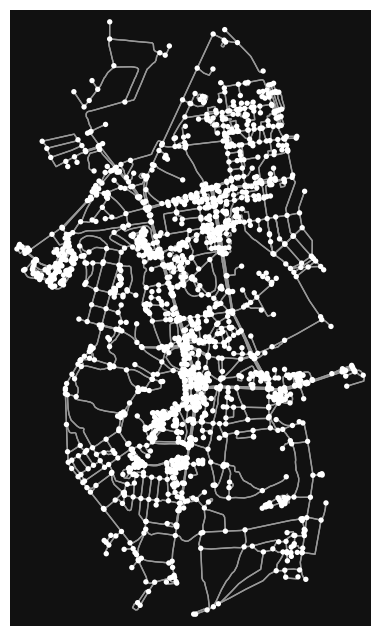

In [ ]:
place = "Суздаль, Владимирская область, Россия"
graph = ox.graph_from_place(
    place,
    network_type="walk" # указываем какой вид сети нам нужен
)
# Отобразим граф
figure, ax = ox.plot_graph(graph)

Чтобы преобразовать граф в `GeoDataFrame`, воспользуемся методом `ox.graph_to_gdfs(nodes=False, edges=True)`. Здесь мы можем использовать параметры `nodes` и `edges`, чтобы выбрать, хотим ли мы получить только узлы, только ребра или и то, и другое:

In [ ]:
# Извлечем только ребра из нашего графа
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid lanes                name      highway  \
u         v          key                                                     
108161339 5584186641 0     11985872     2        улица Ленина    secondary   
          2697093386 0     56383251     2      улица Крупской  residential   
          1901798409 0    264033859     2        улица Ленина    secondary   
108161341 1901862303 0     11985872     2        улица Ленина    secondary   
          1901862302 0     24966823     2  Васильевская улица    secondary   

                         maxspeed  oneway reversed  length     ref service  \
u         v          key                                                     
108161339 5584186641 0         40   False    False   8.738     NaN     NaN   
          2697093386 0        NaN   False     True   9.413     NaN     NaN   
          1901798409 0         40   False     True  14.687     NaN     NaN   
108161341 1901862303 0         40   False     True  11.513     NaN     NaN   
          1901862302 0        NaN   False    False  12.600  17Н-69     NaN   

                                                                   geometry  \
u         v          key                                                      
108161339 5584186641 0    LINESTRING (40.44765 56.42363, 40.44769 56.42355)   
          2697093386 0    LINESTRING (40.44765 56.42363, 40.44750 56.42362)   
          1901798409 0    LINESTRING (40.44765 56.42363, 40.44760 56.42375)   
108161341 1901862303 0    LINESTRING (40.44949 56.41995, 40.44944 56.42004)   
          1901862302 0    LINESTRING (40.44949 56.41995, 40.44970 56.41994)   

                         bridge access width tunnel  
u         v          key                             
108161339 5584186641 0      NaN    NaN   NaN    NaN  
          2697093386 0      NaN    NaN   NaN    NaN  
          1901798409 0      NaN    NaN   NaN    NaN  
108161341 1901862303 0      NaN    NaN   NaN    NaN  
          1901862302 0      NaN    NaN   NaN    NaN

Давайте посмотрим из каких типов улиц состоит наша дорожная сеть города Суздаль.

In [ ]:
edges["highway"].value_counts().head(10)

service             1660
footway             1608
residential         1104
secondary            298
path                 242
track                148
tertiary              88
unclassified          64
[steps, footway]      64
pedestrian            46
Name: highway, dtype: int64

В `OSMnx` есть отдельная функция: `ox.project_graph()`, которая принимает входной граф и `CRS` в качестве параметров и возвращает новый, преобразованный, граф. Если значение `CRS` не указано явно, то преобразование выполняется по умолчанию в **наиболее подходящую для конкретного места зону UTM**.

In [ ]:
# Трансформируем CRS в наиболее подходящую зону UTM
graph = ox.project_graph(graph)

# Преобразуем в геодатафрейм, по умолчанию nodes и edges = True
nodes, edges = ox.graph_to_gdfs(graph)

# Проверим какая система координат сейчас
nodes.crs

<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, northern hemisphere between equator and 84°N, onshore and offshore. Djibouti. Egypt. Eritrea. Ethiopia. Georgia. Iraq. Jordan. Kenya. Lebanon. Russian Federation. Saudi Arabia. Somalia. Sudan. Syria. Türkiye (Turkey). Ukraine.
- bounds: (36.0, 0.0, 42.0, 84.0)
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Сначала нам нужно указать начальную и конечную точку для поиска кратчайшего маршрута.

In [ ]:
origin = (
    ox.geocode_to_gdf("гостиница Суздаль Inn", which_result=1)  # геокодируем
    .to_crs(edges.crs)  # меняем систему координат
    .at[0, "geometry"]  # берем только столбец геометрий
    .centroid  # ищем центроид места
)

destination = (
    ox.geocode_to_gdf("Спасо-Евфимиев мужской монастырь, Суздаль, Россия")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)
print(origin, destination)

POINT (589951.5082749885 6253820.099430898) POINT (588798.2388395325 6255233.057570505)


In [ ]:
# находим ближайшие точки на графе
origin_node_id = ox.distance.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = ox.distance.nearest_nodes(graph, destination.x, destination.y)

print(f'origin_node_id={origin_node_id}, destination_node_id={destination_node_id}')

origin_node_id=2577012396, destination_node_id=2918972168


In [ ]:
# Найдеме кратчайший путь между точками отправления и назначения
route = ox.routing.shortest_path(graph, origin_node_id, destination_node_id)
route

[2577012396,
 2577012147,
 2502158084,
 876507368,
 2577012846,
 876507314,
 4189904718,
 2918971990,
 2918971995,
 2376380228,
 5584186641,
 108161339,
 2697093386,
 2697093394,
 2697093398,
 9547231202,
 2697093449,
 1901862307,
 3618189912,
 2697093456,
 6546846604,
 2697093465,
 2697093474,
 2697093487,
 1992834307,
 1992834321,
 3618189959,
 3618189967,
 1992834339,
 1353908800,
 1900957136,
 2918972035,
 1900957312,
 1901988186,
 1900957345,
 2918972102,
 1900957398,
 2918972115,
 2918972126,
 1900957567,
 2918972168]

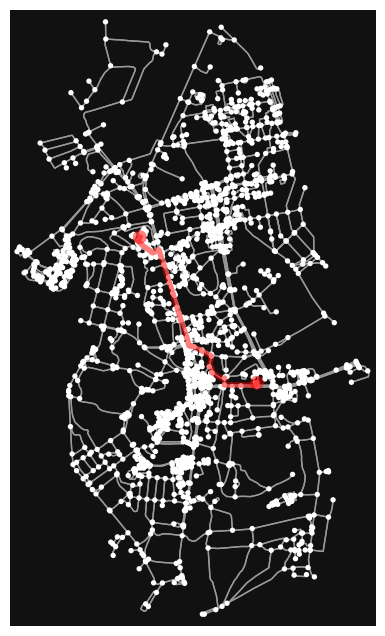

In [ ]:
# Отобразим данный путь
fig, ax = ox.plot_graph_route(graph, route)

Давайте отобразим данный маршрут через folium, чтобы поближе посмотреть на него.

In [ ]:
# Создаем геодатафрейм нашего маршрута через выборку
route_nodes = nodes.loc[route]

# Создадим LineString маршрута, чтобы был один объект
route_line = LineString(list(route_nodes.geometry.values))

# Создадим геодатафрейм из геометрии маршрута
# для отображения на динамической карте
route_geom = gpd.GeoDataFrame(
    {
      "geometry": [route_line],
      "osm_nodes": [route],
    },
    crs=edges.crs
    )

# Отобразим на карте
route_geom.explore()

# Изохроны

Предлагаем для гостиницы из прошлого примера построить изохронную карту в пределах 10 и 15 минутной ходьбы.

Сначала чуток подготовки

In [ ]:
# Импорт библиотек
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt
import folium
from folium import Figure

In [ ]:
# Начальные параметры
city = "Суздаль, Владимирская область, Россия"
place = "гостиница Суздаль Inn"
network_type = 'walk' # указываем какой вид сети нам нужен
trip_times = [10, 15]  # время в минутах
travel_speed = 4.0  # скорость передвижения в км/ч

In [ ]:
# Скачиваем граф
graph = ox.graph_from_place(
    city,
    network_type=network_type
    )

# Трансформируем CRS
graph = ox.project_graph(graph)

# Создаем геодафрейм узлов графа
gdf_nodes = ox.graph_to_gdfs(graph, edges=False)

# Получаем координаты точки
point_of_place = (
    ox.geocode_to_gdf(place, which_result=1)  # геокодируем
    .to_crs(gdf_nodes.crs)  # меняем систему координат
    .at[0, "geometry"]  # берем только столбец геометрий
    .centroid  # ищем центроид места
)

# Ищем ближайший узел к заданной точке
center_node = ox.distance.nearest_nodes(graph,
                                        point_of_place.x,
                                        point_of_place.y)

Давайте поэтапно разберем как это делается, чтобы сложилось понимание.

* Необходимо задать вес в “минутах” для каждого ребра при заданной скорости (возьмем среднюю 4 км/ч). Считать км/ч не удобно, поэтому переведем величину в метр/минута, и посчитаем сколько времени занимает прохождение каждого ребра, если длина ребра известна.

In [ ]:
# переводим скорость в метры/минута
meters_per_minute = travel_speed * 1000 / 60

# Для каждого ребра зададим вес, то есть сколько надо минут, чтобы пройти ребро
for _, _, _, data in graph.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

* Далее рассчитаем до каких узлов графа мы сможем дойти и объединим их все в один полигон для каждой изохроны.

В качестве примера возьмем только "радиус" в 15 минут, и установим значение буфера в 25 метров (так как он проецируется в метрах) для всех наших найденных узлов. Буфер нужен, чтобы увеличить площадь точек, и сделать нагляднее карту.

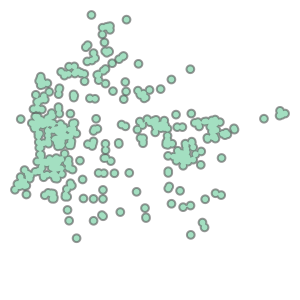

In [ ]:
# Берем "радиус" 15 минут
trip_time = list(sorted(trip_times))[-1]

# Задаем буфер
buffer_val = 25

# с помощью ego_graph библиотеки NetworkX извлекаем подграф из начального графа
# "радиусом" 15 минут из точки = координаты гостиницы, в качестве дистанции берем
# рассчитанное ранее время
subgraph = nx.ego_graph(graph, center_node, radius=trip_time, distance='time')

# Вытаскиваем координаты каждого узла из подграфа
node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]

# Формируем геодатафрейм и задаем индекс
nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
nodes_gdf = nodes_gdf.set_index('id')

# Задаем буфер и объединяем их все
nodes_gdf.buffer(buffer_val).unary_union

Получилось вот такое облако точек или узлов, до которых мы сможем дойти за 15 минут из гостиницы. Аналогично строятся полигоны и для других "радиусов" времени.

Теперь сделаем то же самое для ребер.

Если мы используем ребра вместо узлов, то получим непрерывный набор линий, площадь которого можно увеличить с помощью буфера и объединить в один полигон. Который будет отображать доступность для заданного "радиуса" времени.

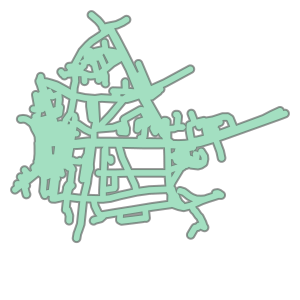

In [ ]:
# Создаем пустой список будущих геометрий ребер
edge_lines = []

# Проходим циклом по всем ребрам
for node_from, node_to in subgraph.edges():

    # Получаем координаты начальной и конечной точки ребра
    f = nodes_gdf.loc[node_from].geometry
    t = nodes_gdf.loc[node_to].geometry

    # Формируем геометрию ребра как линию, если ее нет в начальном графе
    # и добавляем в пустой список
    edge_lookup = graph[node_from][node_to][0].get("geometry", LineString([f, t]))
    edge_lines.append(edge_lookup)

# Из списка формируем геодатафрейм
edges_gdf2 = gpd.GeoDataFrame(geometry=edge_lines)

# Задаем буфер и объединяем их все
edges_gdf2.buffer(buffer_val).unary_union

И получаем полигон, состоящий из улиц, по которым мы можем пройтись до 15 минут. Аналогично строятся полигоны и для других "радиусов" времени.

Далее логично все это объединить в одну функцию и построить полигоны для всех временных интервалов.

In [ ]:
# На вход подаем: изначальный граф, точку для которой будем строить изохроны,
# размеры буферов для узлов и линий, и параметр, который отвечает за заливку
# полигона
def make_iso_polys(G, center_node, trip_time, edge_buff=25, node_buff=50,
                   infill=False):
    # Создаем пустой список наших изохрон
    isochrone_polys = []

    # Проходим циклом по каждому времянному "радиусу"
    for trip_time in sorted(trip_times):

        # Создаем подграф из начального графа
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        # Формируем геодатафрейм узлов, до которых сможем дойти за заданное время
        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)},
                                     geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        # Формируем геодатафрейм ребер, до которых сможем дойти за заданное время
        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G[n_fr][n_to][0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        # Увеличиваем площадь и объединяем
        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # Если хоти сплошной полигон "без дыр", тогда формируем новый полигон
        # из внешних границ объединенного
        if infill:
            new_iso = Polygon(new_iso.exterior)

        # Добавляем полученную изохрону в пустой список
        isochrone_polys.append(new_iso)

    # Возвращаем список
    return isochrone_polys

In [ ]:
# Применяем функцию
isochrone_polys = make_iso_polys(graph, center_node, trip_time,
                                 edge_buff=25, node_buff=25, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys, crs=gdf_nodes.crs)
gdf

,geometry
0,"POLYGON ((589418.671 6253618.121, 589418.475 6..."
1,"POLYGON ((589203.907 6253406.870, 589203.420 6..."


Две изохроны давайте отобразим их на карте. Есть стандарный способ через `OSMnx` и уже знакомый нам через `folium`. Попробуем и так и так.

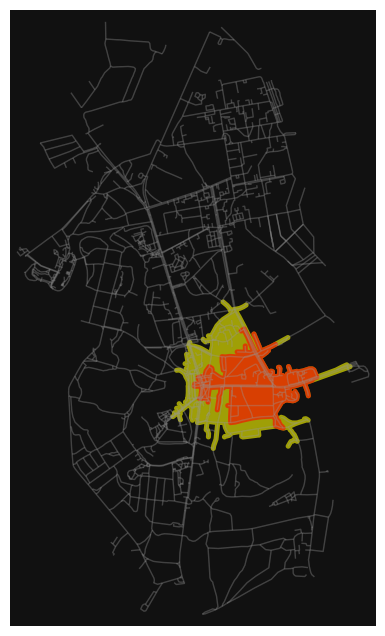

In [ ]:
# Отрисовываем сеть и полученные изохроны
fig, ax = ox.plot_graph(
    graph, show=False, close=False, edge_color="#999999",
    edge_alpha=0.2, node_size=0
    )
gdf.loc[[0]].plot(ax=ax, color="red", alpha=0.6, zorder=-1)
gdf.loc[[1]].plot(ax=ax, color="yellow", alpha=0.6, zorder=-2)
plt.show()

Через Folium

Нужно поменять систему координат и задать центр карты

In [ ]:
gdf = gdf.to_crs('EPSG:4326')

In [ ]:
center_of_map = (
    ox.geocode_to_gdf(place, which_result=1)  # геокодируем
    .at[0, "geometry"]  # берем только столбец геометрий
    .centroid  # ищем центроид места
)

In [ ]:
# задаем размеры окна отображения
fig = Figure(width=900, height=600)

# создаем карту
m = folium.Map(location=[center_of_map.y, center_of_map.x],
               tiles="OpenStreetMap",
               zoom_start=14,
               control_scale=True,
               )

# Первый слой
gdf.loc[[0]].explore(m=m,
            color='red',
            style_kwds={'fillOpacity': 0.7,
                        'weight': 0.5},
            name='Изохрона 10 мин',
            overlay=True,
            )

# Второй слой
gdf.loc[[1]].explore(m=m,
            color='yellow',
            style_kwds={'fillOpacity': 0.7,
                        'weight': 0.5},
            name='Изохрона 15 мин',
            )

# Добавляем маркер (или POI -точки интереса)
folium.Marker(
    location=[center_of_map.y, center_of_map.x], # Координаты маркера
    popup="Суздаль Inn", # Надпись после клика курсором мышки по маркеру
    icon=folium.Icon(color="green"), # вид иконки
).add_to(m) # сразу добавляем маркер к карте

# добавляем карту к окну
m.add_to(fig)

# добавляем контроль слоей, инструмент для их переключения
folium.LayerControl().add_to(m)

# отображаем окно с картой
fig

Метод построения изохрон взят из [примера](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb) библиотеки OSMnx, чуть-чуть видоизменен и разложен на составные части.